# Estimation of time delay

The signal of interest is
\begin{align}
    z(t)=A e^{-\frac{(t-t_c)^2}{2b_w^2}}\sin(2\pi f t)
\end{align}
of width $b_w$ and frequency $f$. In this example we will take $A=b_w=f=1$ and set $t_c=0$.<br>
The probability density function (PDF),

\begin{align} s(t) = B(z)(t) := \frac{z^2(t)}{\int_{\Omega_s} z^2(t)dt} \end{align}

In this example, we are interested in estimating the time delay ($\tau$), i.e. $g_p(t) = t - \tau$. Therefore $z_g(t)=z(t - \tau)$ and $s_g(t) = B(z_g)(t)$. 

Normalized measured signal with noise $\eta \sim \mathcal{N}(0,\sigma^2)$ is given by,
\begin{align} r(t) = B(z_g + \eta)(t) \end{align}

### Parameter estimation in the CDT domain
Let, $\hat{s}$ and $\hat{r}$ be the CDTs of $s(t)$ and $r(t)$, respectively. The time delay estimate is calculated as,
\begin{align}
    \widetilde{\tau}=\mu_r - \mu_s
\end{align}
where $\mu_s$ and $\mu_r$ are center of mass of signals $s$ and $r$, respectively.

#### Create $s(t)$ and $r(t)$

SNR: 9.47544940682685 dB


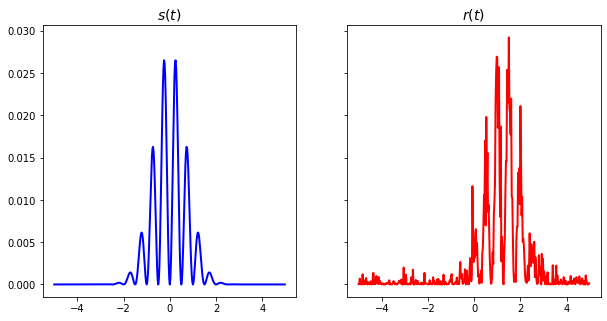

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# To use the CDT first install the PyTransKit package using:
# pip install pytranskit
from pytranskit.optrans.continuous.cdt import CDT

N = 400
dt = 0.025
t = np.linspace(-N/2*dt, (N/2-1)*dt, N) 
f = 1
epsilon = 1e-8

# Original signal
gwin = np.exp(-t**2/2)
z = gwin*np.sin(2*np.pi*f*t) + epsilon
s = z**2/np.linalg.norm(z)**2

# zero mean additive Gaussian noise
sigma = 0.1         # standard deviation
SNRdb = 10*np.log10(np.mean(z**2)/sigma**2)
print('SNR: {} dB'.format(SNRdb))
noise = np.random.normal(0,sigma,N)

# Signal after delay
tau = 50.3*dt
gwin = np.exp(-(t - tau)**2/2)
zg = gwin*np.sin(2*np.pi*f*(t - tau)) + noise + epsilon
r = zg**2/np.linalg.norm(zg)**2

# Plot s and r
fontSize=14
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
ax[0].plot(t, s, 'b-',linewidth=2)
ax[0].set_title('$s(t)$',fontsize=fontSize)

ax[1].plot(t, r, 'r-',linewidth=2)
ax[1].set_title('$r(t)$',fontsize=fontSize)

plt.show()

#### Noise correction
Expression of noise-corrected CDF is given by,
\begin{align}
    \tilde{S}_g(t) = \frac{E[R(t)]\{\mathcal{E}_z+\sigma^2(t_N-t_1)\}-\sigma^2(t-t_1)}{\mathcal{E}_z}, \quad t_1\leq t \leq t_N
\end{align}
where $R(t)$ is the CDF associated with $r(t)$, $\sigma$ is the standard deviation of noise, and $\mathcal{E}_z$ is the total energy of the noise free signal.

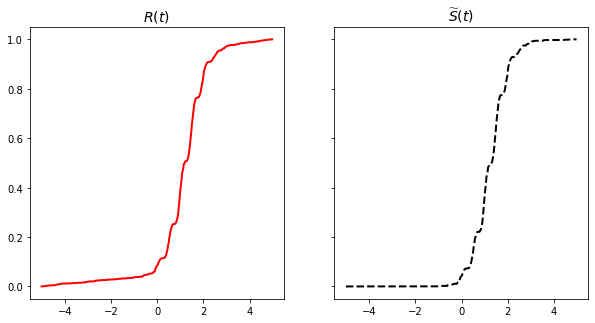

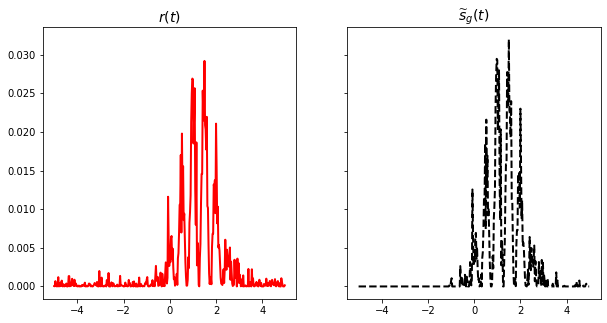

In [22]:
# Calculate the noise-corrected CDF
R = np.cumsum(r)                   # CDF of r(t)
Ez = np.mean(z**2)*(t[-1] - t[0])  # Energy of the signal
Stilde = (R*(Ez+sigma**2*(t[-1]-t[0])) - sigma**2*(t-t[0]))/Ez

# Preserve the non-decreasing property of CDFs
mind = np.argmin(Stilde)
Mind = np.argmax(Stilde)
Stilde[0:mind] = Stilde[mind]
Stilde[Mind:] = Stilde[Mind]
for i in range(len(Stilde)-1):
    if Stilde[i+1]<=Stilde[i]:
        Stilde[i+1] = Stilde[i] + epsilon
        
Stilde = (Stilde - np.min(Stilde))/(np.max(Stilde) - np.min(Stilde))

# Plot R and Stilde
fontSize=14
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
ax[0].plot(t, R, 'r-',linewidth=2)
ax[0].set_title('$R(t)$',fontsize=fontSize)

ax[1].plot(t, Stilde, 'k--',linewidth=2)
ax[1].set_title('$\widetilde{S}(t)$',fontsize=fontSize)

plt.show()

# Calculate the noise-corrected PDF
sg = Stilde
sg[1:] -= sg[:-1].copy()
sg += epsilon

# Plot R and Stilde
fontSize=14
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
ax[0].plot(t, r, 'r-',linewidth=2)
ax[0].set_title('$r(t)$',fontsize=fontSize)

ax[1].plot(t, sg, 'k--',linewidth=2)
ax[1].set_title('$\widetilde{s}_g(t)$',fontsize=fontSize)

plt.show()

#### Calculate CDTs using PyTransKit package

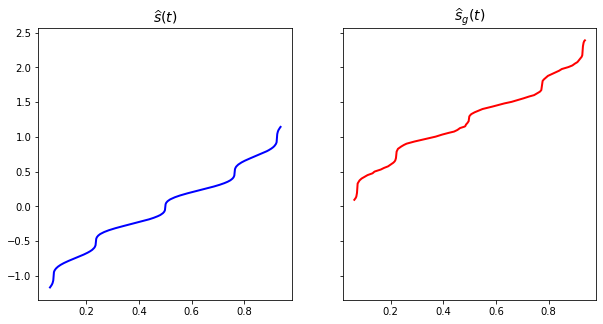

In [23]:
# Reference signal
t0 = np.linspace(0, 1, N)
z0= np.ones(t0.size)+epsilon
s0 = z0**2/np.linalg.norm(z0)**2

# Create a CDT object
cdt = CDT()

# Compute the forward transform
s_hat, s_hat_old, xtilde = cdt.forward(t0, s0, t, s, rm_edge=False)
sg_hat, sg_hat_old, xtilde = cdt.forward(t0, s0, t, sg, rm_edge=False)

# remove the edges
s_hat = s_hat[25:N-25]
sg_hat = sg_hat[25:N-25]
xtilde = xtilde[25:N-25]

# Plot s_hat and sg_hat
fontSize=14
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
ax[0].plot(xtilde, s_hat, 'b-',linewidth=2)
ax[0].set_title('$\widehat{s}(t)$',fontsize=fontSize)

ax[1].plot(xtilde, sg_hat, 'r-',linewidth=2)
ax[1].set_title('$\widehat{s}_g(t)$',fontsize=fontSize)

plt.show()

#### Calculate time delay estimate

In [24]:
estimate = np.mean(sg_hat) - np.mean(s_hat)

print('\nTrue value of time delay: '+str(tau) + ' seconds')
print('Estimated value of time delay: '+str(estimate) + ' seconds\n')



True value of time delay: 1.2575 seconds
Estimated value of time delay: 1.2562758076649236 seconds

